In [152]:
import os
import cv2
import copy
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [153]:
def proc_image(dataset):
    X = []
    Y = []
    
    width = 128
    height = 128
    
    for image_path in os.listdir(dataset):
        image = cv2.imread(f'{dataset}/{image_path}')
        X.append(cv2.resize(image, (width,height), interpolation=cv2.INTER_CUBIC))
        
        if 'y' in image_path.lower():
            Y.append(1)
        else:
            Y.append(0)
            
    return X, Y

In [154]:
X, Y = proc_image('../brain_tumor_dataset')
X = np.asarray(X)
Y = np.asarray(Y)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

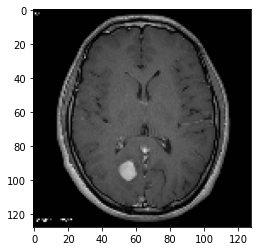

In [155]:
plt.imshow(X[10])

In [156]:
print ("Number of training examples: m_train = " + str(len(x_train)))
print ("Number of testing examples: m_test = " + str(len(x_test)))
print ("Height/Width of each image: num_px = " + str(x_train[0].shape))
print ("x_train shape: " + str(x_train.shape))
print ("y_train shape: " + str(y_train.shape))
print ("x_test shape: " + str(x_test.shape))
print ("y_test shape: " + str(y_test.shape))

Number of training examples: m_train = 202
Number of testing examples: m_test = 51
Height/Width of each image: num_px = (128, 128, 3)
x_train shape: (202, 128, 128, 3)
y_train shape: (202,)
x_test shape: (51, 128, 128, 3)
y_test shape: (51,)


In [157]:
x_train_flatten = x_train.reshape(x_train.shape[0], -1).T
x_test_flatten = x_test.reshape(x_test.shape[0], -1).T

In [158]:
x_train = x_train_flatten / 255
x_test = x_test_flatten / 255

x_train.shape

(49152, 202)

In [159]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    
    return A, Z

In [160]:
def relu(Z):
    A = np.maximum(0, Z)
    
    return A, Z

In [161]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters[f'W{l}'] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters[f'b{l}'] = np.zeros((layer_dims[l], 1))

    
    assert(parameters[f'W{l}'].shape == (layer_dims[l], layer_dims[l - 1]))
    assert(parameters[f'b{l}'].shape == (layer_dims[l], 1))

    
    return parameters

In [162]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    
    return Z, cache

In [163]:
def linear_activation_forward(A_prev, W, b, activation):
    Z, linear_cache = linear_forward(A_prev, W, b)

    if activation == 'sigmoid':
        A, activation_cache = sigmoid(Z)
        
    elif 'relu':
        A, activation_cache = relu(Z)
    
    else:
        print('Undifined actiavtion function.')
        
    cache = (linear_cache, activation_cache)
    
    return A, cache

In [164]:
def L_model_forward(X, parameters):
    L = len(parameters) // 2
    A = X
    caches = []
    
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], 'relu')
        caches.append(cache)
        
    AL, cache = linear_activation_forward(A, parameters[f'W{L}'], parameters[f'b{L}'], activation='sigmoid')
    caches.append(cache)
    
    return AL, caches

In [165]:
def compute_cost(AL, Y):
    m = Y.shape[0]
    cost = -(1/m) * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))
    cost = np.squeeze(cost) 
    
    return cost

In [166]:
def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    return dZ

In [167]:
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) 
    dZ[Z <= 0] = 0
    
    return dZ

In [168]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

In [169]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    elif activation == 'relu':
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    else:
        print('Undifined actiavtion function.')
    
    return dA_prev, dW, db

In [170]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) 
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, activation='sigmoid')
    grads[f'dA{L-1}'] = dA_prev_temp
    grads[f'dW{L}'] = dW_temp
    grads[f'db{L}'] = db_temp
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads[f'dA{l+1}'],
                                                                    current_cache,
                                                                   activation = 'relu')
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        
    return grads

In [171]:
def update_parameters(params, grads, learning_rate):
    parameters = params.copy()
    L = len(parameters) // 2
    
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]
        
    return parameters

In [172]:
def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2
    p = np.zeros((1,m))
    
    probas, caches = L_model_forward(X, parameters)

    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
            
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p


In [178]:
layers_dims = [49152, 14, 1]

In [179]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.009, num_iterations = 3000, print_cost=False):
    np.random.seed(1)
    costs = [] 
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, y_train)
        grads = L_model_backward(AL,Y,caches)
        parameters = update_parameters(parameters,grads,learning_rate)
        
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs

In [180]:
parameters, costs = L_layer_model(x_train, y_train, layers_dims, num_iterations = 3000, print_cost = True)

Cost after iteration 0: 0.6930762577945454
Cost after iteration 100: 0.5301512150144743
Cost after iteration 200: 0.3323136599708571
Cost after iteration 300: 0.245180470672424
Cost after iteration 400: 0.10338482262022095
Cost after iteration 500: 0.06128225565746279
Cost after iteration 600: 0.040054662285408875
Cost after iteration 700: 0.028298789920324918
Cost after iteration 800: 0.02121744041023684
Cost after iteration 900: 0.016637754154697888
Cost after iteration 1000: 0.013501487857123623
Cost after iteration 1100: 0.011251508394715504
Cost after iteration 1200: 0.009575877945478865
Cost after iteration 1300: 0.00828963217021849
Cost after iteration 1400: 0.0072774199671042815
Cost after iteration 1500: 0.006463289597135194
Cost after iteration 1600: 0.005796858538017005
Cost after iteration 1700: 0.005243169455788336
Cost after iteration 1800: 0.0047767354328332404
Cost after iteration 1900: 0.004379314465248269
Cost after iteration 2000: 0.004037298463186625
Cost after iter

In [181]:
pred_train = predict(x_train, y_train, parameters)

Accuracy: 0.9999999999999998


In [183]:
pred_test = predict(x_train, y_train, parameters)

Accuracy: 0.9999999999999998
